YOLO 的網路輸出是一個 7x7x30 的 tensor,

而今天的程式碼範例的目標是讓大家由程式碼實現損失函數的計算，透過損失函數衡量一張圖片經由 YOLO 模型辨識後的結果和標記檔的差距有多遠。
今天的範例，採用的是YOLOv1_tiny的網絡。

資料來源: https://github.com/solaris33/dl_cv_tensorflow_10weeks/blob/master/week10/tensorflow-yolo/yolo/net/yolo_net.py

輸入所需的library，這邊會呼叫到其他的程式碼(YoloTinyNet.py)，
預測的類型(classes_name)共有20種。

首先，我們先開一個"Day35.YOLO 細節理解 - 損失函數程式碼解讀"的google雲端空間資料夾，
把系統的程式碼上傳到這個資料夾中。
下面程式碼，我們先把google的雲端硬碟連結到colab上，在使用python將工作路徑切換到你想要的文件夾，就可以在colab上運行python並抓取到相對的檔案。

首先執行程式後，下方會跳出一個超連結，
1.   點選你的google帳號
2.   點選允許colab能操作你的雲端硬碟，
3.   跳出另一個畫面，點右邊的小方格，複製連結，
4.   貼到Enter your authorization code:下方的小框框，按下enter。

In [0]:
"""
from google.colab import drive
drive.mount('/content/drive')
# 指定google drive雲端硬碟的跟目錄，名為drive
#!mkdir -p drive
#!google-drive-ocamlfuse drive
import os
# 此處為google drive中的文件路徑，drive為之前指定的工作跟目錄，要加上位置
# 如果存放的路徑有變，從/content/drive/My Drive/XXXXX...做調整
path = "/content/drive/My Drive/Day35.YOLO 細節理解 - 損失函數程式碼解讀"
os.chdir(path)

!ls
"""

In [0]:
!ls yolo/net

__init__.py  net.py  __pycache__  yolo_net.py  yolo_tiny_net.py


In [1]:
import os
import sys
path = "../Day35.YOLO細節理解-損失函數"

sys.path.append(os.path.join(path, "../Day35.YOLO細節理解-損失函數/yolo/net"))
sys.path.append(path)


# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from yolo.net.yolo_tiny_net import YoloTinyNet 
import tensorflow.compat.v1 as tf 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import keras

config = ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True

keras.backend.set_session(InteractiveSession(config=config))
session = InteractiveSession(config=config)

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]
tf.reset_default_graph() #避免Python的控制檯會儲存上次執行結束的變數

/home/shinfu/anaconda3/envs/yolo_v1/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
import os
import subprocess
if not os.path.exists("models/pretrain/yolo_tiny.ckpt"):
# 下載 yolo_tiny 的網路權重
# print("Model doesn't exist, downloa`ding...")
# os.system("wget https://drive.google.com/file/d/0B-yiAeTLLamRekxqVE01Yi1RRlk/view?usp=sharing")
# print("Converting yolov3.weights to yolo.h5...")
  os.system("python3 convert.py yolov3.cfg yolov3.weights models/pretrain/yolo_tiny.ckpt")
else:
  print("Model exist")

讀入資料集

In [4]:
# 下載圖片範例，如果已經下載過就可以註解掉
# !wget https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true -O dog.jpg
img = cv2.imread("../data/dog_bicycle.jpg") # 讀取範例圖片
h, w, _ = img.shape
print(img.shape)

def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # plt.imshow 預設圖片是 rgb 的
    plt.show()

(576, 768, 3)


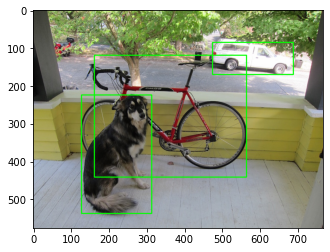

In [5]:
boxes = np.array([[128, 224, 314, 537], [475, 85, 689, 170], [162, 119, 565, 441]]).astype(float)
# 把 bboxes 坐標以原圖的 resolution normalize 到 0~1 之間
boxes[:, [0, 2]] = boxes[:, [0, 2]] / img.shape[1]
boxes[:, [1, 3]] = boxes[:, [1, 3]] / img.shape[0]

img_show = img.copy()
for x1, y1, x2, y2 in boxes:
    cv2.rectangle(img_show, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (0, 255, 0), 2)
show(img_show)

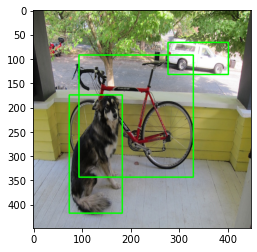

[ 74.66666667 174.22222222 183.16666667 417.66666667]
[277.08333333  66.11111111 401.91666667 132.22222222]
[ 94.5         92.55555556 329.58333333 343.        ]


In [6]:
#模擬影像的標記檔結果
# yolo輸入的是448*448，所以原始大小要先縮成448*448，所以原本的標記框大小也要對應轉換
dy = 448/576
dx = 448/768
boxes = np.array([[128*dx, 224*dy, 314*dx, 537*dy], 
                  [475*dx,  85*dy, 689*dx, 170*dy], 
                  [162*dx, 119*dy, 565*dx, 441*dy]]).astype(float)
np_img = cv2.imread('../data/dog_bicycle.jpg')
resized_img = cv2.resize(np_img, (448, 448))
img_show = resized_img.copy()
for x1, y1, x2, y2 in boxes:
    cv2.rectangle(img_show, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
show(img_show)
print(boxes[0,])
print(boxes[1,])
print(boxes[2,])
#可以檢視一下，轉換後標記的結果的確能框住物體

In [7]:
#標記檔: labels轉成 loss 函數所需的格式,(xmin,ymin,xmax,ymax)-->(x_center, y_center, w, h, class) in (448,448)
labels = np.zeros((3, 5)) 

# x_center, y_center
labels [:,0]=(boxes[:,0]+boxes[:,2])/2
labels [:,1]=(boxes[:,1]+boxes[:,3])/2

# w, h
labels [:,2]=boxes[:,2]-boxes[:,0]
labels [:,3]=boxes[:,3]-boxes[:,1]

# classes
labels [0,4]=6
labels [1,4]=1
labels [2,4]=11
print(labels)

[[128.91666667 295.94444444 108.5        243.44444444   6.        ]
 [339.5         99.16666667 124.83333333  66.11111111   1.        ]
 [212.04166667 217.77777778 235.08333333 250.44444444  11.        ]]


In [8]:
print(labels)
labels = tf.reshape(labels, (3, 5))
labels = tf.cast(labels, tf.float32) 
#為了後續運算轉成 float32
print(labels)

[[128.91666667 295.94444444 108.5        243.44444444   6.        ]
 [339.5         99.16666667 124.83333333  66.11111111   1.        ]
 [212.04166667 217.77777778 235.08333333 250.44444444  11.        ]]
Tensor("Cast:0", shape=(3, 5), dtype=float32)


In [15]:
#輸出層解碼
def process_predicts(predicts):
  #類別
  p_classes = predicts[0, :, :, 0:20]
  #個別bbox包含有物件的機率
  C = predicts[0, :, :, 20:22]
  #個別bbox的標記框位置
  coordinate = predicts[0, :, :, 22:]

  p_classes = np.reshape(p_classes, (7, 7, 1, 20))
  C = np.reshape(C, (7, 7, 2, 1))

  #對應相乘，產生𝑝(〖𝐶𝑙𝑎𝑠𝑠〗_𝑗 |𝑜𝑏𝑗𝑒𝑐𝑡)*𝑃(𝑜𝑏𝑗𝑒𝑐𝑡)
  P = C * p_classes

  index = np.argmax(P) #返還最大值索引(486)
  #print(index) #486
  index = np.unravel_index(index, P.shape)#(7, 7, 1, 20)
  #print(index) #(1, 5, 0, 6)

  class_num = index[3]

  coordinate = np.reshape(coordinate, (7, 7, 2, 4))

  max_coordinate = coordinate[index[0], index[1], index[2], :]

  xcenter = max_coordinate[0]
  #print("xcenter=",xcenter)
  ycenter = max_coordinate[1]
  #print("ycenter=",ycenter)
  w = max_coordinate[2]
  #print("w=",w)
  h = max_coordinate[3]
  #print("h=",h)
  
  #index[1] : x 網格位置
  xcenter = (index[1] + xcenter) * (448/7.0)
  # index[0]: y網格位置
  ycenter = (index[0] + ycenter) * (448/7.0)

  w = w * 448
  h = h * 448

  xmin = xcenter - w/2.0
  ymin = ycenter - h/2.0

  xmax = xmin + w
  ymax = ymin + h

  return xmin, ymin, xmax, ymax, class_num

### 設定YoloTinyNet 
透過YoloTinyNet產生一個預測結果

In [10]:
common_params = {'image_size': 448, 
                 'num_classes': 20, 
                 'batch_size': 1}
net_params = {'cell_size': 7, 'boxes_per_cell':2, 'weight_decay': 0.0005, 'class_scale': 2.0,
              'object_scale':1.0, 'noobject_scale': 0.5, 'coord_scale': 5.0}

net = YoloTinyNet(common_params, net_params, test=False)
#net = YoloNet(common_params, net_params, test=True)

# Tensorflow 如果想如果想要從外部傳入data,那就要用到 tf.placeholder()，然後以這種形式傳輸數據， sess.run(***,feed_dict={input: **})
# 傳值的工作交給 sess.run(),需要傳入的值放在 feed_dict={}，一一對應每一個 input, placeholder和 feed_dict={}是綁定在一出現的。 
image = tf.placeholder(tf.float32, (1, 448, 448, 3))
predicts = net.inference(image)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





In [13]:
#Session 是 Tensorflow 開啟一個對話，執行輸出結果。
sess = tf.Session()
np_img = cv2.imread('../data/dog_bicycle.jpg')
resized_img = cv2.resize(np_img, (448, 448))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)


np_img = np_img.astype(np.float32)

np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, 448, 448, 3))

#一些設定的函數，先跳過。
saver = tf.train.Saver(net.trainable_collection)
#輸入網絡架構的參數檔
saver.restore(sess, '../Day35.YOLO細節理解-損失函數/models/pretrain/yolo_tiny.ckpt')
#開啟對話，進行預測
np_predict = sess.run(predicts, feed_dict={image: np_img})
print(np_predict.shape)
print(np_predict)


INFO:tensorflow:Restoring parameters from ../Day35.YOLO細節理解-損失函數/models/pretrain/yolo_tiny.ckpt
(1, 7, 7, 30)
[[[[-4.85867262e-04  2.61655096e-02  1.22950822e-02 ...  5.94526410e-01
     2.40998924e-01  3.06236297e-01]
   [-1.84577499e-02  4.27619740e-02  1.49253868e-02 ...  3.35297287e-01
     3.29137266e-01  2.58317471e-01]
   [-2.01963373e-02  3.12887765e-02  1.35347657e-02 ...  3.54574382e-01
     3.42966914e-01  2.55582213e-01]
   ...
   [-2.82485485e-02  2.36656629e-02 -5.27477637e-03 ...  6.74339652e-01
     4.26294118e-01  3.28908116e-01]
   [-1.33474227e-02  2.66973898e-02 -7.99678266e-04 ...  7.17429638e-01
     4.73707438e-01  3.71665537e-01]
   [-2.08642893e-03 -2.43414100e-03  1.23035237e-02 ...  5.82476616e-01
     3.51009727e-01  3.17552894e-01]]

  [[-2.75943801e-02  4.14202362e-02 -5.04403934e-03 ...  4.45856720e-01
     2.37064108e-01  4.23232764e-01]
   [-3.39969508e-02  5.71538024e-02  1.16020553e-02 ...  4.47640896e-01
     4.02588844e-01  4.34626460e-01]
   [-4.77

### 預測出來產生的結果檔

In [16]:
xmin, ymin, xmax, ymax, class_num = process_predicts(np_predict)
print("output")
print(xmin)
print(ymin)
print(xmax)
print(ymax)
print(class_num) #"car"
class_name = classes_name[class_num]
print(class_name)

#draw the box
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255))
cv2.putText(resized_img, class_name, (int(xmin), int(ymin)), 2, 1.5, (0, 0, 255))

#output result
cv2.imwrite('dog_out.jpg', resized_img)

output
210.11976528167725
-7.49359130859375
456.27899074554443
215.19951629638672
6
car


True

接下來透過三個函數，計算一張圖片經由 YOLO 模型辨識後的結果和標記檔的差距有多遠。


1.   iou -->計算兩個bbox的iou值
2.   body1-->標記框做轉換，然後和預測框計算產生損失函數
3.   loss -->計算每一個標記框和所有預測框的損失




### loss function 函數

In [17]:
# 參數設定
image_size=448
num_classes=20
batch_size=1

cell_size=7
boxes_per_cell=2
weight_decay=0.0005
class_scale=2.0
object_scale=1.0
noobject_scale= 0.5
coord_scale=5.0

In [18]:
def iou(boxes1, boxes2):
    """calculate ious
    self代表某呼叫這個函數的物件本身
    Args:
      boxes1:(代表預測框) 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  
      4分別代表====> (x_center, y_center, w, h)
      boxes2:(代表實際框) 1-D tensor [4] ===> (x_center, y_center, w, h)
    Return:
      回傳iou的值
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      
    """
    # (x_center-w/2),(y_center-h/2),(x_center+w/2),(y_center+h/2)=(左上方座標，右下方座標)
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])
    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point
    #計算交集的左上方點，和右下方點
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    #交集(intersection)
    intersection = rd - lu 
    #交集面積
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]
    #只取長寬>0的才做計算
    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)
    
    inter_square = mask * inter_square
    
    #calculate the boxs1 square and boxs2 square
    #計算聯集面積，等於兩個方形區塊-交集面積(calculate the boxs1 square and boxs2 square)
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])
    return inter_square/(square1 + square2 - inter_square + 1e-6)

In [19]:
def cond1(num, object_num, loss, predict, label, nilboy):
    """
    if num < object_num
    """
    return num < object_num

In [20]:
def body1(num, object_num, loss, predict, labels, nilboy):
    """
    calculate loss
    Args:
      predict(預測框結果): 3-D tensor [cell_size, cell_size, 5 * boxes_per_cell]
      labels(標記框) : [max_objects, 5]  (x_center, y_center, w, h, class)
      #max_objects,紀錄物體的總數量
    """
    # 用 num 控制現在是計算第幾個物件的標記框，取出來計算

    label = labels[num:num+1, :]
    label = tf.reshape(label, [-1])

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #判斷是否有某一物體標記框中心落在網格i 中 ==>1^{object}_{i}
    #objects
    min_x = (label[0] - label[2] / 2) / (image_size / cell_size)
    max_x = (label[0] + label[2] / 2) / (image_size / cell_size)

    min_y = (label[1] - label[3] / 2) / (image_size / cell_size)
    max_y = (label[1] + label[3] / 2) / (image_size / cell_size)
    #計算不大於 min_x的最大整數
    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)
    #計算不小於 min_x的最小整數
    max_x = tf.ceil(max_x)
    max_y = tf.ceil(max_y)

    #相減，計算物體涵蓋的cell範圍
    temp = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    objects = tf.ones(temp, tf.float32)

    temp = tf.cast(tf.stack([min_y, cell_size - max_y, min_x, cell_size - max_x]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    objects = tf.pad(objects, temp, "CONSTANT")

    #calculate objects  tensor [CELL_SIZE, CELL_SIZE]
    #calculate responsible tensor [CELL_SIZE, CELL_SIZE]-->1^{object}_{ij}
    #判斷第 I 個網格中第 j 個bbox是否負責這個物體
    center_x = label[0] / (image_size / cell_size)
    center_x = tf.floor(center_x)

    center_y = label[1] / (image_size / cell_size)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    temp = tf.cast(tf.stack([center_y, cell_size - center_y - 1, center_x, cell_size -center_x - 1]), tf.int32)
    temp = tf.reshape(temp, (2, 2))
    response = tf.pad(response, temp, "CONSTANT")
    #objects = response

    #calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    #取出 box
    predict_boxes = predict[:, :, num_classes + boxes_per_cell:]
    
    #重新 reshape
    predict_boxes = tf.reshape(predict_boxes, [cell_size, cell_size, boxes_per_cell, 4])

    predict_boxes = predict_boxes * [image_size / cell_size, image_size / cell_size, image_size, image_size]

    base_boxes = np.zeros([cell_size, cell_size, 4])

    for y in range(cell_size):
      for x in range(cell_size):
        #nilboy
        base_boxes[y, x, :] = [image_size / cell_size * x, image_size / cell_size * y, 0, 0]
    base_boxes = np.tile(np.resize(base_boxes, [cell_size, cell_size, 1, 4]), [1, 1, boxes_per_cell, 1])

    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])
    #calculate C [cell_size, cell_size, boxes_per_cell]
    C = iou_predict_truth * tf.reshape(response, [cell_size, cell_size, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    #判斷第 I 個網格中第 j 個bbox是否負責這個物體
    I = iou_predict_truth * tf.reshape(response, (cell_size, cell_size, 1))
    
    max_I = tf.reduce_max(I, 2, keepdims=True)

    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (cell_size, cell_size, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I 


    p_C = predict[:, :, num_classes:num_classes + boxes_per_cell]

    #calculate truth x,y,sqrt_w,sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))
    #sqrt_w = tf.abs(label[2])
    #sqrt_h = tf.abs(label[3])

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]


    p_sqrt_w = tf.sqrt(tf.minimum(image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(image_size * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))
    #calculate truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), num_classes, dtype=tf.float32)

    #calculate predict p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:num_classes]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(objects, (cell_size, cell_size, 1)) * (p_P - P)) * class_scale
    #class_loss = tf.nn.l2_loss(tf.reshape(response, (cell_size, cell_size, 1)) * (p_P - P)) * class_scale

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * object_scale

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * noobject_scale

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(image_size/cell_size)) +
                 tf.nn.l2_loss(I * (p_y - y)/(image_size/cell_size)) +
                 tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/ image_size +
                 tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/image_size) * coord_scale

    nilboy = I

    with tf.Session() as sess1:
        print("第幾個標記框",sess1.run(num))
        #print(sess1.run(num)) 
        print(sess1.run(label)) 
        print("class_loss =",sess1.run(class_loss))
        print("object_loss=",sess1.run(object_loss))
        print("noobject_loss=",sess1.run(noobject_loss))
        print("coord_loss=",sess1.run(coord_loss))
    return num + 1, object_num, [loss[0] + class_loss, loss[1] + object_loss, loss[2] + noobject_loss, loss[3] + coord_loss], predict, labels, nilboy

In [21]:
def loss(predicts, labels, objects_num):
    """Add Loss to all the trainable variables

    Args:
      predicts: 4-D tensor [batch_size, cell_size, cell_size, 5 * boxes_per_cell]
      ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
      labels  : 3-D tensor of [batch_size, max_objects, 5]
      objects_num: 1-D tensor [batch_size]
    """
    print("loss")
    class_loss = tf.constant(0, tf.float32) #bbox物件類別計算損失
    object_loss = tf.constant(0, tf.float32) #bbox 物件信心度計算損失
    noobject_loss = tf.constant(0, tf.float32) #bbox 無物件信心度計算損失
    coord_loss = tf.constant(0, tf.float32) #bbox的定位計算損失
    loss = [0, 0, 0, 0]
    #每一張圖都各自計算 loss
    for i in range(batch_size):
      predict = predicts[i, :, :, :]
      #print("predict==",predicts.shape.as_list())
      label = labels[i, :, :]
      object_num = objects_num[i]
      nilboy = tf.ones([7,7,2])
      #以每一個標記框分別計算每一張圖是否有那一個物件，進行損失函數的運算
      tuple_results = body1(tf.constant(0), object_num, [class_loss, object_loss, noobject_loss, coord_loss], predict, label, nilboy)
      for j in range(4):
        loss[j] = loss[j] + tuple_results[2][j]
      tuple_results = body1(tf.constant(1), object_num, [class_loss, object_loss, noobject_loss, coord_loss], predict, label, nilboy)
  
      for j in range(4):
        loss[j] = loss[j] + tuple_results[2][j]
      tuple_results = body1(tf.constant(2), object_num, [class_loss, object_loss, noobject_loss, coord_loss], predict, label, nilboy)
     
      for j in range(4):
        loss[j] = loss[j] + tuple_results[2][j]
      nilboy = tuple_results[5]
    
    return loss

### 計算標記框和預測框的loss function

In [22]:
predicts=tf.reshape(np_predict,(1, 7, 7, 30))
labels=tf.reshape(labels, (1,3, 5))
#output_loss=net.loss(predicts, labels,  tf.constant(3, shape=[1]))
output_loss=loss(predicts, labels,  tf.constant(3, shape=[1]))
print("預測結果和標記框的損失量")
with tf.Session() as sess1: 
    print(sess1.run(output_loss)) 

sess.close()

loss
第幾個標記框 0
[128.91667 295.94446 108.5     243.44444   6.     ]
class_loss = 9.5156145
object_loss= 0.079215266
noobject_loss= 0.079646535
coord_loss= 0.46610114
第幾個標記框 1
[339.5       99.166664 124.833336  66.111115   1.      ]
class_loss = 6.9121933
object_loss= 0.039668012
noobject_loss= 0.08317398
coord_loss= 0.1514467
第幾個標記框 2
[212.04167 217.77777 235.08333 250.44444  11.     ]
class_loss = 20.678493
object_loss= 0.2624038
noobject_loss= 0.08252484
coord_loss= 0.09616779
預測結果和標記框的損失量
[37.1063, 0.38128707, 0.24534535, 0.7137157]
